In [1]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

<IPython.core.display.Javascript object>

## Data Preprocessing

* Regex cheatsheet
    * https://www.rexegg.com/regex-quickstart.html
* Datetime format
    * http://strftime.org/

In [2]:
def rawToDf(file):
    with open(file, 'r') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s', raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall('\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s', raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
   
    # converting date-time pattern which is of type String to type datetime, format is to be specified for the whole string where the placeholders are extracted by the method    
    try:
        df['date_time'] = pd.to_datetime(df['date_time'], format='%m/%d/%y, %I:%M %p - ') #10/20/19, 10:24 pm - 
    except:
        df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y, %I:%M %p - ') #20/10/2019, 10:24 pm -
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [3]:
me = "Prajwal Prashanth"

### Data

In [4]:
df = rawToDf('Hermanos_group.txt')

In [5]:
df.head()

,date_time,user,msg
0,2018-05-14 20:20:00,Prajwal Prashanth,Unbidu
1,2018-05-14 20:20:00,Sandesh..!!,Adhe
2,2018-05-14 20:20:00,Sandesh..!!,Asayya
3,2018-05-14 20:20:00,Venkat,😂
4,2018-05-14 20:20:00,Sandesh..!!,Adhe***


In [6]:
df.shape # no. of msgs

(39999, 3)

### No. of Images, group notifications and dropping them

In [7]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

(855, 3)

In [8]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(41, 3)

In [9]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [10]:
df.reset_index(inplace=True, drop=True)
df.shape

(39103, 3)

## Q 1)
## Who is the most active member of the group. Who is the least active. Is it same on weekday weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [13]:
df.groupby("user")["msg"].count().sort_values(ascending=False)

user
Sandesh..!!          9280
Sri Hari Colle       9162
Venkat               5264
Nikil DB             4954
Prajwal Prashanth    4384
Billa                1743
Ktg                  1436
manish lakshman      1293
Abhishek Dharani      587
Kushal Ramakanth      342
Prajwal Kaaadi        191
Kranti Jio            180
Srinidhi Nie          103
Keshava                94
+91 98863 53469        90
Name: msg, dtype: int64

In [14]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [15]:
df.weekday.value_counts(sort=True)

Sunday       7267
Monday       6044
Wednesday    5655
Thursday     5491
Friday       5465
Saturday     5081
Tuesday      4100
Name: weekday, dtype: int64

In [16]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

## Q 2)
## Count of all the emoticons that i have used till date.

In [19]:
df.head()

,date_time,user,msg,weekday,is_weekend
0,2018-05-14 20:20:00,Prajwal Prashanth,Unbidu,Monday,False
1,2018-05-14 20:20:00,Sandesh..!!,Adhe,Monday,False
2,2018-05-14 20:20:00,Sandesh..!!,Asayya,Monday,False
3,2018-05-14 20:20:00,Venkat,😂,Monday,False
4,2018-05-14 20:20:00,Sandesh..!!,Adhe***,Monday,False


In [20]:
df["user"].unique()

array(['Prajwal Prashanth', 'Sandesh..!!', 'Venkat', 'Sri Hari Colle',
       'Nikil DB', '+91 98863 53469', 'Ktg', 'Billa', 'manish lakshman',
       'Kushal Ramakanth', 'Keshava', 'Abhishek Dharani', 'Srinidhi Nie',
       'Kranti Jio', 'Prajwal Kaaadi'], dtype=object)

In [21]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [22]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

😂 - 74
😢 - 22
✌ - 18
👎 - 18
👍 - 15
😶 - 4
😭 - 3
😅 - 2
🙏 - 2
😓 - 1


## Q 3)
## What can my activity say about my sleep cycle?

In [23]:
def to_hour(val):
    return val.hour

In [24]:
df['hour'] = df['date_time'].apply(to_hour)

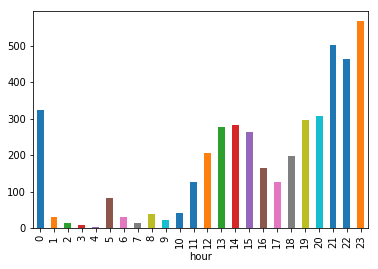

In [25]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?



In [26]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

Sandesh..!!          9280
Sri Hari Colle       9162
Venkat               5264
Nikil DB             4954
Prajwal Prashanth    4384
Billa                1743
Ktg                  1436
manish lakshman      1293
Abhishek Dharani      587
Kushal Ramakanth      342
Prajwal Kaaadi        191
Kranti Jio            180
Srinidhi Nie          103
Keshava                94
+91 98863 53469        90
Name: user, dtype: int64

In [27]:
top5_users = msgs_per_user.index.tolist()[:5]
top5_users

['Sandesh..!!', 'Sri Hari Colle', 'Venkat', 'Nikil DB', 'Prajwal Prashanth']

In [28]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

,date_time,user,msg,weekday,is_weekend,hour
0,2018-05-14 20:20:00,Prajwal Prashanth,Unbidu,Monday,False,20
1,2018-05-14 20:20:00,Sandesh..!!,Adhe,Monday,False,20
2,2018-05-14 20:20:00,Sandesh..!!,Asayya,Monday,False,20
3,2018-05-14 20:20:00,Venkat,😂,Monday,False,20
4,2018-05-14 20:20:00,Sandesh..!!,Adhe***,Monday,False,20


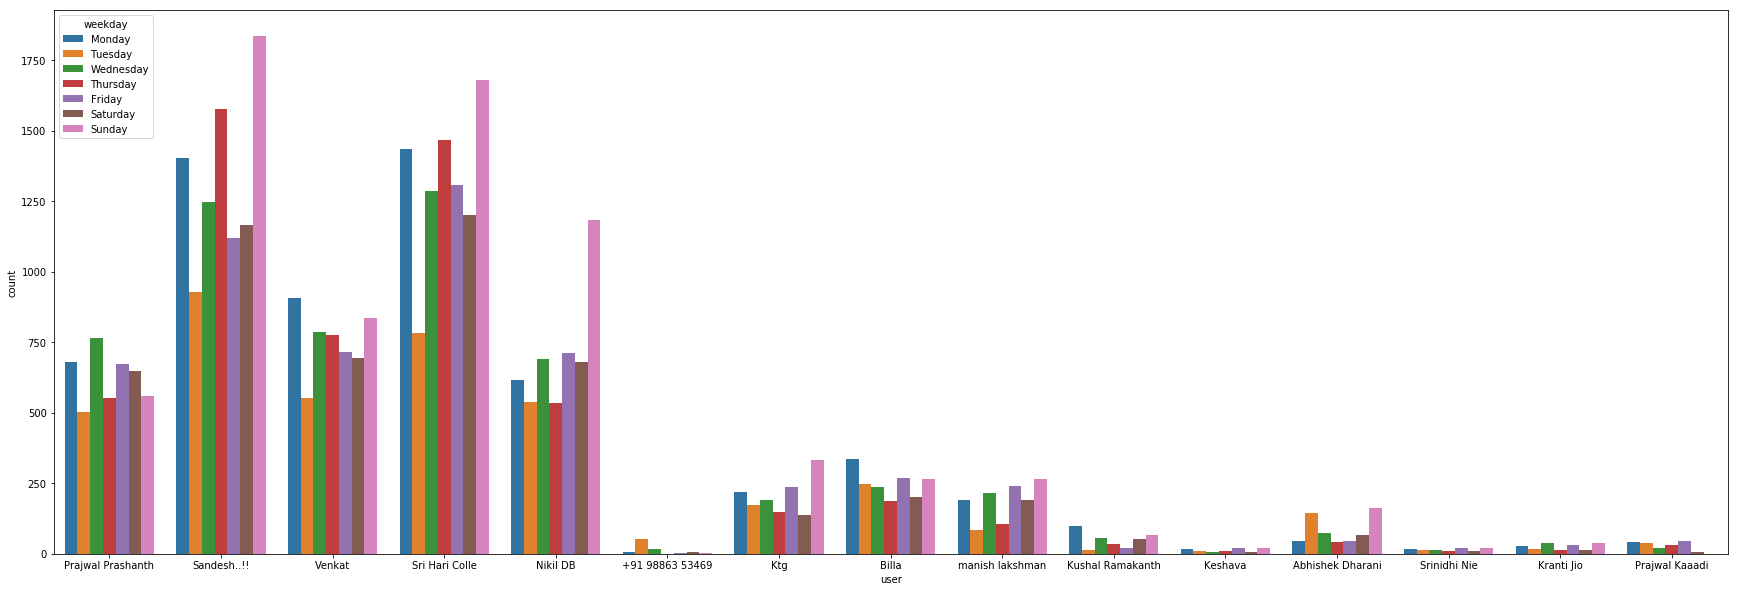

In [29]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

In [30]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

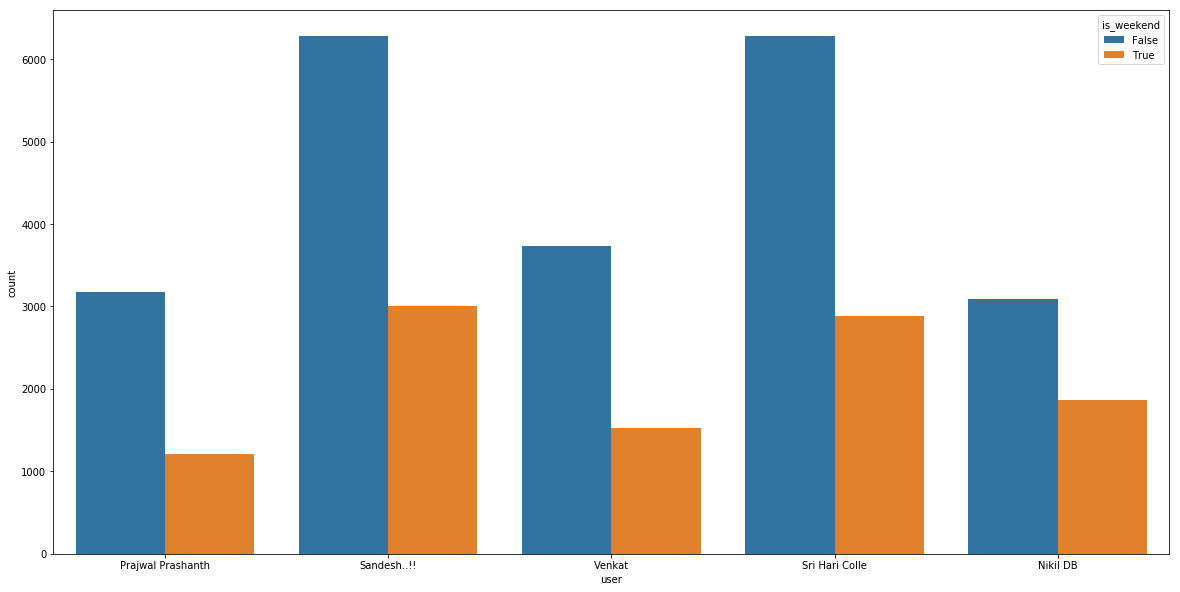

In [31]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

In [32]:
def word_count(val):
    return len(val.split())

In [33]:
df['no_of_words'] = df['msg'].apply(word_count)

In [34]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [35]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

91876

In [36]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

41129

In [38]:
total_words_weekday/5

18375.200000000001

In [39]:
total_words_weekend/2

20564.5

In [40]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Sandesh..!!          32255
Sri Hari Colle       27207
Venkat               20753
Prajwal Prashanth    17719
Nikil DB             16828
Billa                 4783
manish lakshman       4198
Ktg                   3701
Abhishek Dharani      2001
Kushal Ramakanth      1331
Prajwal Kaaadi         764
Kranti Jio             513
+91 98863 53469        447
Srinidhi Nie           287
Keshava                218
Name: no_of_words, dtype: int64

In [41]:
(df.groupby('user')['no_of_words'].sum()/df.groupby('user').size()).sort_values(ascending=False)

user
+91 98863 53469      4.966667
Prajwal Prashanth    4.041743
Prajwal Kaaadi       4.000000
Venkat               3.942439
Kushal Ramakanth     3.891813
Sandesh..!!          3.475754
Abhishek Dharani     3.408859
Nikil DB             3.396851
manish lakshman      3.246713
Sri Hari Colle       2.969548
Kranti Jio           2.850000
Srinidhi Nie         2.786408
Billa                2.744119
Ktg                  2.577298
Keshava              2.319149
dtype: float64

In [42]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Prajwal Prashanth    4.041743
Venkat               3.942439
Sandesh..!!          3.475754
Nikil DB             3.396851
Sri Hari Colle       2.969548
dtype: float64

In [43]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user               is_weekend
Nikil DB           False         3.361165
                   True          3.456009
Prajwal Prashanth  False         4.001259
                   True          4.148179
Sandesh..!!        False         3.497849
                   True          3.429570
Sri Hari Colle     False         2.973726
                   True          2.960444
Venkat             False         4.051138
                   True          3.676913
dtype: float64

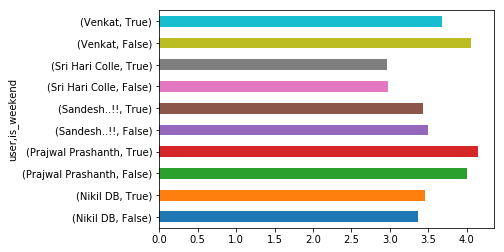

In [44]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

## Q 5)
## Most Usage - Time of Day

In [45]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,494.0,578.0,367.0,206.0,650.0,248.0,478.0
1,30.0,188.0,253.0,181.0,9.0,286.0,144.0
2,3.0,124.0,13.0,7.0,8.0,5.0,6.0
3,8.0,5.0,NaN,NaN,1.0,1.0,1.0
4,1.0,2.0,NaN,5.0,1.0,2.0,1.0


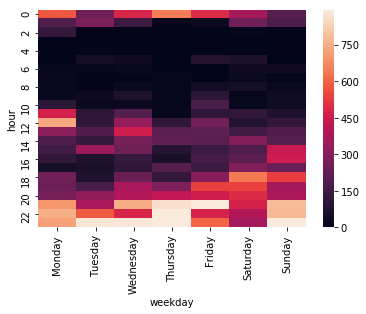

In [46]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6)
## In any group, do I have any inclination towards responding to someone? 

In [47]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[    0    11    22 ..., 39096 39098 39100] (4384,)


In [48]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[   -1    10    21 ..., 39095 39097 39099] (4384,)


In [49]:
prev_msgs_index = np.delete(prev_msgs_index, 0)
prev_msgs_index

array([   10,    21,    29, ..., 39095, 39097, 39099])

In [50]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(4383, 7)

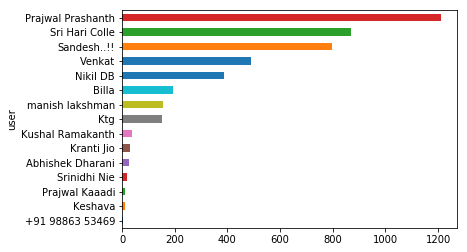

In [51]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

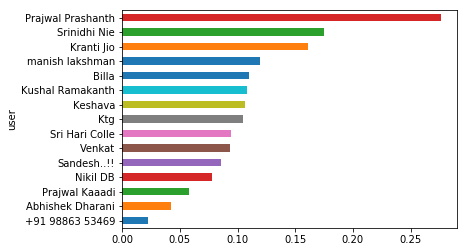

In [52]:
(df_replies.groupby(["user"])["msg"].size()/df.groupby(["user"])["msg"].size()).sort_values().plot(kind='barh')

## Q 7)
## Which are the most common words?

In [53]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


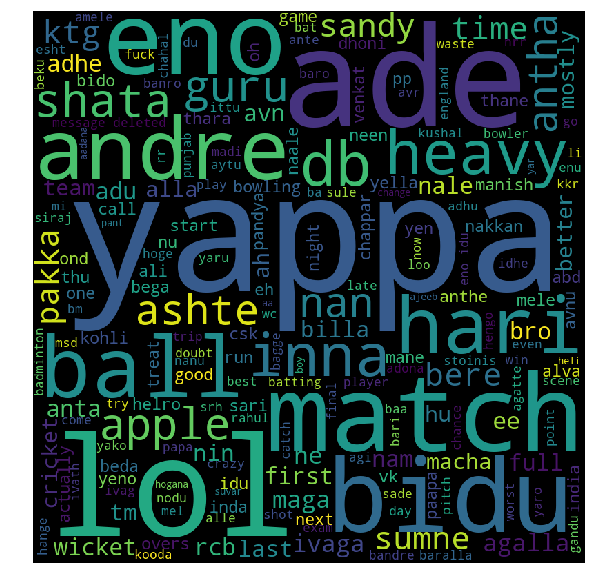

In [54]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

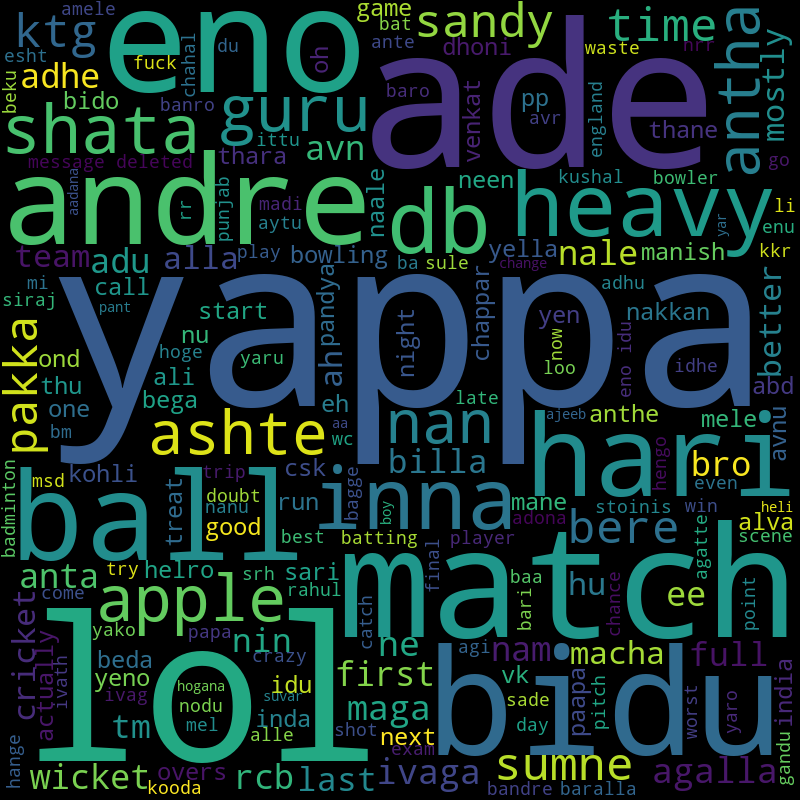

In [55]:
wordcloud.to_image()